**Название проекта:**

Исследование показов рекламы для геймеров.

**Цель исследования:**

Провести исследование показов рекламы с целью понять на сколько отличается eCPM в зависимости от географии (города) юзера, версии ОС и других параметров. Интересны любые инсайты и находки по eCPM-ам. 

***Задачи исследования:***

1. Загрузить данные и выполнить их предобработку.
2. Для каждого формата рекламы:
*    построить распределение средних eCPM-ов юзеров;
*    построить распределение eCPM-ов по городам, версиям ОС;
*    построить распределение доходов по городам, версиям ОС.

3. Учесть статистическую значимость (отобразить, отфильтровать незначимое или хотя бы прокомментировать). Объяснить решение.
4. Описать наблюдения и вывод по исследованию.
5. Дополнительные (по желанию) исследовать:
*    какой процент доходов содержит информацию о городе юзера;
*    зависит ли eCPM от времени дня.

**Исходные данные:**

*    В распоряжении есть исторические <a href="https://drive.google.com/file/d/1h2eXP4EyL8hYT2kZ0wmShAtp8Qz8HpNq/view?usp=sharing"> данные </a> о показах рекламы для юзеров США.


***Описание данных:***

**profile_id** – id юзера

**event_json** - данные о событии показа рекламы
-    **ad_type** – формат рекламы (int, banner или rv)
-    **placement** – когда/где был показ рекламы в игре
-    **view_index** – номер показа конкретного формата рекламы для юзера (не поддерживается для баннеров)
-    **revenue** – доход от конкретного показа рекламы (eCPM = revenue * 1000)
-    **ads_ltv** – накапливающийся доход от рекламы, равен сумме всех revenue юзера
-    **network_name** – рекламная сеть, от которой был показ

Остальные столбцы должны быть интуитивно понятны

____

**Данное исследование разделим на несколько частей.**

<a href='#link_1'> ***Часть 1. Изучение общей информации и подготовка данных:***</a>

*    <a href='#link_1.1'>1.1 Импорт библиотек.</a>
*    <a href='#link_1.2'>1.2 Написание функций get_info и missing_data.</a>
*    <a href='#link_1.3'>1.3 Загрузка данных и изучение первичной информации.</a>
*    <a href='#link_1.4'>1.4 Преобразование стобца event_json на отдельные столбцы.</a>
*    <a href='#link_1.5'>1.5 Обработка пропусков.</a>
*    <a href='#link_1.6'>1.6 Проверка на наличие и обработка неявных дубликатов.</a>


<a href='#link_2'> ***Часть 2. Анализ данных***</a>

*    <a href='#link_2.1'>2.1 Распределение средних eCPM-ов юзеров для каждого формата рекламы.</a>
*    <a href='#link_2.2'>2.2 Распределение средних eCPM-ов по городам, версиям ОС.</a>
*    <a href='#link_2.3'>2.3 Распределение доходов по городам, версиям ОС.</a>
*    <a href='#link_2.4'>2.4 Распределение средних eCPM-ов по времени суток.</a>
*    <a href='#link_2.5'>2.5 Стоимость рекламы в разных компаниях.</a>


<a href='#link_3'> ***Часть 3. Вывод***</a>


<a id='link_1'> </a>
## Откроем файл, изучим и подготовим данные

<a id='link_1.1'> </a>
### Импорт библиотек

In [1]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import re

# pd.set_option('display.float_format', '{:,.5f}'.format)
pd.set_option('display.max_columns', None)

#import warnings
#warnings.filterwarnings("ignore")

<a id='link_1.2'> </a>
### Написание функций get_info и missing_data

In [2]:
# Функция для получения первичной информации об исходных данных
def get_info(df):
    '''
    Функция для получения первичной информации об исходных данных:
       - типы данных,
       - количество пропусков,
       - кол-во дубликатов, 
       - характеристики числовых столбцов
       - размер таблицы
       - первые 5 строк таблицы
    '''
    print(100 * "-")
    print('Общее описание полученных данных:')
    print(100 * "-")
    df.info()
    print(100 * "-")
    print('Описание количественных переменных:')
    print(100 * "-")    
    display(df.describe(datetime_is_numeric=True))
    print(100 * "-")
    print(f'Количество полных дубликатов в таблице = {df.duplicated().sum()}')
    print(100 * "-")
    print(f'Размер таблицы = {df.shape}')
    print(100 * "-")
    print('Первые 5 строк таблицы:')
    display(df.head())
    

In [3]:
def missing_data(df):
    '''
    Функция для подсчета и визуализации пропусков.
    
    На вход подается:
        DataFrame.
    На выходе получаем:
        heatmap c визуализацией пропусков;
        количество пропусков в каждом столбце;
        доля пропусков по данному столбцу.
    '''
    # heatmap with missed values
    sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
    
    # quantity and persentage of missing values
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])  
    
    return missing_data

<a id='link_1.3'> </a>
### Загрузка данных и изучение первичной информации

In [4]:
# Загрузим данные
df_raw = pd.read_csv('dataset.csv', parse_dates=[8, 10])

In [5]:
get_info(df_raw)

----------------------------------------------------------------------------------------------------
Общее описание полученных данных:
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 860079 entries, 0 to 860078
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   profile_id               860065 non-null  object        
 1   os_version               860079 non-null  object        
 2   device_manufacturer      860079 non-null  object        
 3   device_model             860079 non-null  object        
 4   device_type              860079 non-null  object        
 5   device_locale            860079 non-null  object        
 6   event_name               860079 non-null  object        
 7   event_json               860079 non-null  object        
 8   event_datetime           860

,event_datetime,event_timestamp,event_receive_datetime,event_receive_timestamp
count,860079,8.600790e+05,860079,8.600790e+05
mean,2022-02-05 22:02:44.454852352,1.644088e+09,2022-02-05 22:14:03.385469440,1.644088e+09
min,2022-01-29 17:42:32,1.643467e+09,2022-02-03 00:00:02,1.643836e+09
25%,2022-02-05 02:27:19,1.644017e+09,2022-02-05 02:35:47,1.644018e+09
50%,2022-02-06 02:02:31,1.644102e+09,2022-02-06 02:08:50,1.644103e+09
75%,2022-02-06 22:46:42,1.644177e+09,2022-02-06 22:54:35,1.644177e+09
max,2022-02-07 23:59:59,1.644268e+09,2022-02-07 23:59:59,1.644268e+09
std,NaN,1.058604e+05,NaN,1.055928e+05


----------------------------------------------------------------------------------------------------
Количество полных дубликатов в таблице = 0
----------------------------------------------------------------------------------------------------
Размер таблицы = (860079, 16)
----------------------------------------------------------------------------------------------------
Первые 5 строк таблицы:


,profile_id,os_version,device_manufacturer,device_model,device_type,device_locale,event_name,event_json,event_datetime,event_timestamp,event_receive_datetime,event_receive_timestamp,connection_type,operator_name,country_iso_code,city
0,JLjpGzDHBQm,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-04 20:02:28,1643994148,2022-02-06 17:58:19,1644159499,wifi,NaN,US,Norwalk
1,JLjpGzDHBQm,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-04 20:02:45,1643994165,2022-02-06 17:58:19,1644159499,wifi,NaN,US,Norwalk
2,JLkVacrzHY6,11,Google,Pixel 2,phone,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-05 17:53:05,1644072785,2022-02-06 16:59:29,1644155969,wifi,Verizon,US,Charlotte
3,JMC6wG3cX0f,10,Samsung,Galaxy S9,phone,en_US,c_ad_revenue,"{""ad_type"":""int"",""placement"":""next_level"",""vie...",2022-02-06 17:09:01,1644156541,2022-02-06 17:09:24,1644156564,wifi,T-Mobile,US,Cocoa
4,JLzWWTJfi1b,10,Samsung,Galaxy S9,phone,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-06 17:15:38,1644156938,2022-02-06 17:16:16,1644156976,cell,Verizon,US,NaN


In [6]:
# Посмотрим детально одну ячейку столбца 'event_json'
df_raw['event_json'][0]

'{"ad_type":"banner","placement":"","view_index":1,"session_view_index":0,"cur_ticks":637795729492245130,"session_length":705.8807,"revenue":0.000510313,"ads_ltv":0.487876676518837,"ecpm_sma":0.511508107185364,"normalized_ecpm_sma":0.511508107185364,"value":0.000510313,"currency":"USD","ad_country_code":"US","network_name":"Google AdMob","ad_unit_id":"64c6b1114ea8c1cc","ad_network_placement":"ca-app-pub-7511632782617496/8825263691","creativeId":"CJ3XirfD5vUCFYPnKAUdG3MOYQ"}'

**Промежуточный вывод:**

Столбец 'event_json' имеет дополнительные данные, которые необходимо разбить на столбцы. Столбцы разделены запятыми, а назавание столбца и его значение разделены двоеточием. Также каждое буквенное значение заключено в дополнительные кавычки. Напишем функции для очистки от лишних кавычек и разбиение значений столбца 'event_json' на отдельные столбцы.

<a id='link_1.4'> </a>
### Преобразование стобца event_json на отдельные столбцы

In [7]:
def convertToDict(row):
    '''
    Функцию для преобразования списка в словарь с разделителем между ключом и значением ':'
    '''
    splited_row = [a.split(':') for a in row]
    row_dict = {}
    for item in splited_row:
        key = item[0]
        value = item[1]
        row_dict[key] = value
    return row_dict

In [8]:
def clean_text(row):
    '''
    Функция для очистки строки:
       - от символов в начале строки, 
       - от символов в конце строки, 
       - двойных кавычек
    '''
    # Очистка от символов в начале и в конце строки
    row = re.sub(r'(^\W+)|(\W+$)', '', row)
    # Очистка от лишних двойных кавычек
    row = re.sub(r'(")', '', row)
    return row

In [9]:
# Выделим необходимый столбец
s = df_raw['event_json']

In [10]:
# Очистим при помощи функции 'clean_text'
s = s.apply(clean_text)

In [11]:
# Разобъем на отдельные элементы
s = s.str.split(',')

In [12]:
# Преобразуем значения ячеек в словари при помощи функции 'convertToDict'
s = s.apply(convertToDict)

In [13]:
# Преобразуем наш столбец в DataFrame
new_df = s.apply(pd.Series)

In [14]:
# Посмотрим получившийся DataFrame
new_df.head()

,ad_type,placement,view_index,session_view_index,cur_ticks,session_length,revenue,ads_ltv,ecpm_sma,normalized_ecpm_sma,value,currency,ad_country_code,network_name,ad_unit_id,ad_network_placement,creativeId
0,banner,,1,0,637795729492245130,705.8807,0.000510313,0.487876676518837,0.511508107185364,0.511508107185364,0.000510313,USD,US,Google AdMob,64c6b1114ea8c1cc,ca-app-pub-7511632782617496/8825263691,CJ3XirfD5vUCFYPnKAUdG3MOYQ
1,banner,,1,0,637795729659949790,722.6512,0.000510313,0.488386989518837,0.511388599872589,0.511388599872589,0.000510313,USD,US,Google AdMob,64c6b1114ea8c1cc,ca-app-pub-7511632782617496/8825263691,CNa-lL_D5vUCFZrpKAUdU2QBDQ
2,banner,,1,0,637796515863735930,431.8129,0.0023861625,0.67847875732725,0.928597450256348,0.928597450256348,0.0023861625,USD,US,APPLOVIN_EXCHANGE,64c6b1114ea8c1cc,banner_regular,pandora-58
3,int,next_level,1,1,637797353426827330,125.9496,0.0138937835693359,0.0138937835693359,13.7826328277588,13.8937835693359,0.0138937835693359,USD,US,AppLovin,3ab7705b07ebb75f,inter_regular,13045364
4,banner,,1,0,637797357392197840,12.71129,0.00682757,0.0605709444258423,1.6602817773819,1.6602817773819,0.00682757,USD,US,Google AdMob,64c6b1114ea8c1cc,ca-app-pub-7511632782617496/6197324251,CMTi5e-h6_UCFUdVwQodt9EIMw


In [15]:
# Присоединим полученные столбцы к основной таблице и удалим ненужный 'event_json'
df = pd.concat([df_raw,new_df],axis=1).drop('event_json',axis=1)

In [16]:
df.head()

,profile_id,os_version,device_manufacturer,device_model,device_type,device_locale,event_name,event_datetime,event_timestamp,event_receive_datetime,event_receive_timestamp,connection_type,operator_name,country_iso_code,city,ad_type,placement,view_index,session_view_index,cur_ticks,session_length,revenue,ads_ltv,ecpm_sma,normalized_ecpm_sma,value,currency,ad_country_code,network_name,ad_unit_id,ad_network_placement,creativeId
0,JLjpGzDHBQm,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,2022-02-04 20:02:28,1643994148,2022-02-06 17:58:19,1644159499,wifi,NaN,US,Norwalk,banner,,1,0,637795729492245130,705.8807,0.000510313,0.487876676518837,0.511508107185364,0.511508107185364,0.000510313,USD,US,Google AdMob,64c6b1114ea8c1cc,ca-app-pub-7511632782617496/8825263691,CJ3XirfD5vUCFYPnKAUdG3MOYQ
1,JLjpGzDHBQm,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,2022-02-04 20:02:45,1643994165,2022-02-06 17:58:19,1644159499,wifi,NaN,US,Norwalk,banner,,1,0,637795729659949790,722.6512,0.000510313,0.488386989518837,0.511388599872589,0.511388599872589,0.000510313,USD,US,Google AdMob,64c6b1114ea8c1cc,ca-app-pub-7511632782617496/8825263691,CNa-lL_D5vUCFZrpKAUdU2QBDQ
2,JLkVacrzHY6,11,Google,Pixel 2,phone,en_US,c_ad_revenue,2022-02-05 17:53:05,1644072785,2022-02-06 16:59:29,1644155969,wifi,Verizon,US,Charlotte,banner,,1,0,637796515863735930,431.8129,0.0023861625,0.67847875732725,0.928597450256348,0.928597450256348,0.0023861625,USD,US,APPLOVIN_EXCHANGE,64c6b1114ea8c1cc,banner_regular,pandora-58
3,JMC6wG3cX0f,10,Samsung,Galaxy S9,phone,en_US,c_ad_revenue,2022-02-06 17:09:01,1644156541,2022-02-06 17:09:24,1644156564,wifi,T-Mobile,US,Cocoa,int,next_level,1,1,637797353426827330,125.9496,0.0138937835693359,0.0138937835693359,13.7826328277588,13.8937835693359,0.0138937835693359,USD,US,AppLovin,3ab7705b07ebb75f,inter_regular,13045364
4,JLzWWTJfi1b,10,Samsung,Galaxy S9,phone,en_US,c_ad_revenue,2022-02-06 17:15:38,1644156938,2022-02-06 17:16:16,1644156976,cell,Verizon,US,NaN,banner,,1,0,637797357392197840,12.71129,0.00682757,0.0605709444258423,1.6602817773819,1.6602817773819,0.00682757,USD,US,Google AdMob,64c6b1114ea8c1cc,ca-app-pub-7511632782617496/6197324251,CMTi5e-h6_UCFUdVwQodt9EIMw


In [17]:
# df.to_csv('cleaned_dataset.csv', index=False)

<a id='link_1.5'> </a>
### Обработка пропусков

In [18]:
# df = pd.read_csv('cleaned_dataset.csv', parse_dates=[7, 9])

In [19]:
get_info(df)

----------------------------------------------------------------------------------------------------
Общее описание полученных данных:
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 860079 entries, 0 to 860078
Data columns (total 32 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   profile_id               860065 non-null  object        
 1   os_version               860079 non-null  object        
 2   device_manufacturer      860079 non-null  object        
 3   device_model             860079 non-null  object        
 4   device_type              860079 non-null  object        
 5   device_locale            860079 non-null  object        
 6   event_name               860079 non-null  object        
 7   event_datetime           860079 non-null  datetime64[ns]
 8   event_timestamp          860

,event_datetime,event_timestamp,event_receive_datetime,event_receive_timestamp
count,860079,8.600790e+05,860079,8.600790e+05
mean,2022-02-05 22:02:44.454852352,1.644088e+09,2022-02-05 22:14:03.385469440,1.644088e+09
min,2022-01-29 17:42:32,1.643467e+09,2022-02-03 00:00:02,1.643836e+09
25%,2022-02-05 02:27:19,1.644017e+09,2022-02-05 02:35:47,1.644018e+09
50%,2022-02-06 02:02:31,1.644102e+09,2022-02-06 02:08:50,1.644103e+09
75%,2022-02-06 22:46:42,1.644177e+09,2022-02-06 22:54:35,1.644177e+09
max,2022-02-07 23:59:59,1.644268e+09,2022-02-07 23:59:59,1.644268e+09
std,NaN,1.058604e+05,NaN,1.055928e+05


----------------------------------------------------------------------------------------------------
Количество полных дубликатов в таблице = 0
----------------------------------------------------------------------------------------------------
Размер таблицы = (860079, 32)
----------------------------------------------------------------------------------------------------
Первые 5 строк таблицы:


,profile_id,os_version,device_manufacturer,device_model,device_type,device_locale,event_name,event_datetime,event_timestamp,event_receive_datetime,event_receive_timestamp,connection_type,operator_name,country_iso_code,city,ad_type,placement,view_index,session_view_index,cur_ticks,session_length,revenue,ads_ltv,ecpm_sma,normalized_ecpm_sma,value,currency,ad_country_code,network_name,ad_unit_id,ad_network_placement,creativeId
0,JLjpGzDHBQm,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,2022-02-04 20:02:28,1643994148,2022-02-06 17:58:19,1644159499,wifi,NaN,US,Norwalk,banner,,1,0,637795729492245130,705.8807,0.000510313,0.487876676518837,0.511508107185364,0.511508107185364,0.000510313,USD,US,Google AdMob,64c6b1114ea8c1cc,ca-app-pub-7511632782617496/8825263691,CJ3XirfD5vUCFYPnKAUdG3MOYQ
1,JLjpGzDHBQm,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,2022-02-04 20:02:45,1643994165,2022-02-06 17:58:19,1644159499,wifi,NaN,US,Norwalk,banner,,1,0,637795729659949790,722.6512,0.000510313,0.488386989518837,0.511388599872589,0.511388599872589,0.000510313,USD,US,Google AdMob,64c6b1114ea8c1cc,ca-app-pub-7511632782617496/8825263691,CNa-lL_D5vUCFZrpKAUdU2QBDQ
2,JLkVacrzHY6,11,Google,Pixel 2,phone,en_US,c_ad_revenue,2022-02-05 17:53:05,1644072785,2022-02-06 16:59:29,1644155969,wifi,Verizon,US,Charlotte,banner,,1,0,637796515863735930,431.8129,0.0023861625,0.67847875732725,0.928597450256348,0.928597450256348,0.0023861625,USD,US,APPLOVIN_EXCHANGE,64c6b1114ea8c1cc,banner_regular,pandora-58
3,JMC6wG3cX0f,10,Samsung,Galaxy S9,phone,en_US,c_ad_revenue,2022-02-06 17:09:01,1644156541,2022-02-06 17:09:24,1644156564,wifi,T-Mobile,US,Cocoa,int,next_level,1,1,637797353426827330,125.9496,0.0138937835693359,0.0138937835693359,13.7826328277588,13.8937835693359,0.0138937835693359,USD,US,AppLovin,3ab7705b07ebb75f,inter_regular,13045364
4,JLzWWTJfi1b,10,Samsung,Galaxy S9,phone,en_US,c_ad_revenue,2022-02-06 17:15:38,1644156938,2022-02-06 17:16:16,1644156976,cell,Verizon,US,NaN,banner,,1,0,637797357392197840,12.71129,0.00682757,0.0605709444258423,1.6602817773819,1.6602817773819,0.00682757,USD,US,Google AdMob,64c6b1114ea8c1cc,ca-app-pub-7511632782617496/6197324251,CMTi5e-h6_UCFUdVwQodt9EIMw


,Total,Percent
city,323708,0.376370
operator_name,18879,0.021950
profile_id,14,0.000016
ecpm_sma,0,0.000000
cur_ticks,0,0.000000
session_length,0,0.000000
revenue,0,0.000000
ads_ltv,0,0.000000
normalized_ecpm_sma,0,0.000000
view_index,0,0.000000


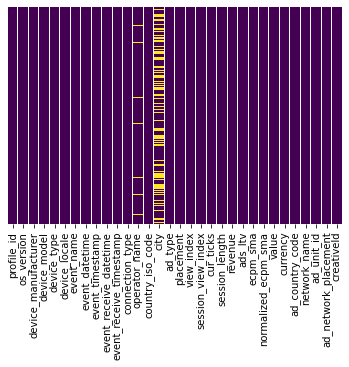

In [20]:
# Проверим наличие пропусков в таблице, вызвав функцию 'missing_data'
missing_data(df)

**Промежуточный вывод:**

Мы видим пропущенные данные в столбцах:

    placement - 95%
    city - 38%
    operator_name - 22%
    profile_id - менее 0.01% (14 штук)

Столбец 'placement' удалим.

Cтолбцы 'city' и 'operator'_name имеют довольно большое количество пропусков, но данные столбцы нужны для исследования поэтому данные столбцы оставим и пустые значения заменим на значение 'unknown'

Строки с пустыми значениями столбца 'profile_id' удалим, так как им очень мало. 

In [21]:
# Заменим пустые значения заменим на значение 'unknown'
df[['operator_name', 'city']] = df[['operator_name', 'city']].fillna('unknown')
df.shape

(860079, 32)

In [22]:
# Удалим столбец 'placement'
df = df.drop('placement', axis=1)
df.shape

(860079, 31)

In [23]:
# удалим строки с пустыми значениями
df = df.dropna(subset=['profile_id'])
df.shape

(860065, 31)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 860065 entries, 0 to 860078
Data columns (total 31 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   profile_id               860065 non-null  object        
 1   os_version               860065 non-null  object        
 2   device_manufacturer      860065 non-null  object        
 3   device_model             860065 non-null  object        
 4   device_type              860065 non-null  object        
 5   device_locale            860065 non-null  object        
 6   event_name               860065 non-null  object        
 7   event_datetime           860065 non-null  datetime64[ns]
 8   event_timestamp          860065 non-null  int64         
 9   event_receive_datetime   860065 non-null  datetime64[ns]
 10  event_receive_timestamp  860065 non-null  int64         
 11  connection_type          860065 non-null  object        
 12  operator_name   

**Вывод:** Видим, что пропусков больше нет. Работу с пропусками закончили

<a id='link_1.6'> </a>
### Проверка на наличие и обработка неявных дубликатов

In [25]:
# Приведем все целые числовые данные к типу integer
int_col = ['event_timestamp', 'event_receive_timestamp', 'view_index', 'session_view_index', 'cur_ticks']
df[int_col] = df[int_col].astype('int64')

In [26]:
# Приведем все дробные числовые данные к типу float
float_col = ['session_length', 'revenue', 'ads_ltv', 'ecpm_sma', 'normalized_ecpm_sma', 'value']
df[float_col] = df[float_col].astype('float64')

In [27]:
# Найдем все столбцы с категориальными значениями
cat_col = df.dtypes[df.dtypes=="object"].index.values
cat_col

array(['profile_id', 'os_version', 'device_manufacturer', 'device_model',
       'device_type', 'device_locale', 'event_name', 'connection_type',
       'operator_name', 'country_iso_code', 'city', 'ad_type', 'currency',
       'ad_country_code', 'network_name', 'ad_unit_id',
       'ad_network_placement', 'creativeId'], dtype=object)

In [28]:
uni_col1 = []
uni_col2 = []

for i in cat_col:
    print(f'столбец "{i}" имеет {df[i].nunique()} уникальных значений')
    print(100 * "-")
    if df[i].nunique() > 1 and df[i].nunique() < 35:
        uni_col1.append(i)
    if df[i].nunique() > 1 and df[i].nunique() < 15:
        uni_col2.append(i)

столбец "profile_id" имеет 4226 уникальных значений
----------------------------------------------------------------------------------------------------
столбец "os_version" имеет 11 уникальных значений
----------------------------------------------------------------------------------------------------
столбец "device_manufacturer" имеет 34 уникальных значений
----------------------------------------------------------------------------------------------------
столбец "device_model" имеет 284 уникальных значений
----------------------------------------------------------------------------------------------------
столбец "device_type" имеет 2 уникальных значений
----------------------------------------------------------------------------------------------------
столбец "device_locale" имеет 9 уникальных значений
----------------------------------------------------------------------------------------------------
столбец "event_name" имеет 1 уникальных значений
-----------------------------

In [29]:
for i in uni_col1:
    print('Уникальные значения столбца ', i)
    print(sorted(df[i].unique()))
    print(100 * "-")

Уникальные значения столбца  os_version
['10', '11', '12', '5.0.2', '6.0.1', '7.0', '7.1.1', '7.1.2', '8.0.0', '8.1.0', '9']
----------------------------------------------------------------------------------------------------
Уникальные значения столбца  device_manufacturer
['AEEZO', 'AT&T', 'Alcatel', 'Asus', 'Blu', 'Cricket', 'Dish', 'FIH', 'Google', 'Huawei', 'JOYAR', 'Kyocera', 'LG', 'Lenovo', 'Maxwest', 'Motorola', 'Nokia', 'OnePlus', 'Onn (Walmart)', 'POCO', 'Razer', 'Redmi', 'Samsung', 'Schok', 'T-Mobile', 'TCL', 'Teracube', 'Ulefone', 'Verizon Wireless', 'Wiko', 'Xiaomi', 'Yulong', 'Zte', 'deejoy']
----------------------------------------------------------------------------------------------------
Уникальные значения столбца  device_type
['phone', 'tablet']
----------------------------------------------------------------------------------------------------
Уникальные значения столбца  device_locale
['en_AU', 'en_CA', 'en_GB', 'en_IN', 'en_NL', 'en_US', 'fr_FR', 'ko_KR', 'zh-Han

**Промежуточный вывод:**

    Столбец  'os_version' имеет промежуточные операционные системы типа '7.0', '7.1.1', '7.1.2'. Скорей всего их можно привести к целому числу (например 7). Но скорей всего это не существенно, так как довольно старая операционная система и значений не так много.

    Столбец 'network_name' имеет значения 'APPLOVIN_EXCHANGE' и 'AppLovin', которые скорей всего относятся к компании AppLovin'. Поэтому приведем их к одному значению.
    
    Остальныые столбцы неявных дубликатов не имеют.

In [30]:
# Заменим все значения 'APPLOVIN_EXCHANGE' на 'AppLovin'
df['network_name'] = df['network_name'].replace('APPLOVIN_EXCHANGE','AppLovin')

In [31]:
for i in uni_col2:
    print('Количество значений и процентное содержание для каждого уникального значения столбца ', i)
#     print(df[i].value_counts())
    print(pd.concat([df[i].value_counts(), df[i].value_counts(normalize=True)], axis=1))
    print(100 * "-")

Количество значений и процентное содержание для каждого уникального значения столбца  os_version
       os_version  os_version
12         407587    0.473903
11         209057    0.243071
10         150871    0.175418
9           66662    0.077508
8.1.0        9249    0.010754
8.0.0        8016    0.009320
7.0          4057    0.004717
7.1.2        1811    0.002106
7.1.1        1342    0.001560
5.0.2         709    0.000824
6.0.1         704    0.000819
----------------------------------------------------------------------------------------------------
Количество значений и процентное содержание для каждого уникального значения столбца  device_type
        device_type  device_type
phone        835653     0.971616
tablet        24412     0.028384
----------------------------------------------------------------------------------------------------
Количество значений и процентное содержание для каждого уникального значения столбца  device_locale
            device_locale  device_locale
en_

**Промежуточный вывод:**

    os_version - большее количество рекламы приходится на операционные системы 12, 11, 10 (почти 90%)
    device_type - большее количество рекламы приходится телефоны. На планшеты приходится чуть меньше 3%
    device_locale и ad_country_code - более 99% приходится на en_US и US соответственно, и это не удивительно ведь данные взяты по USA
    connection_type - большинство рекламы приходится на сеть wifi, что говорит о том, что в основном геймеры используют траффик wifi
    ad_type и ad_unit_id имеют одинаковые значения, что говорит о том, что id и названия соответствуют друг другу
    ad_type - большая часть приходится на banner (более 94%)
    network_name - количество рекламы между собой приблизительно поделили Google AdMob и AppLovin. Интересно будет посмотреть, какая платформа приносит больше денег.
    

<a id='link_2'> </a>
## Анализ данных

<a id='link_2.1'> </a>

### Построим распределение средних eCPM-ов юзеров для каждого формата рекламы.

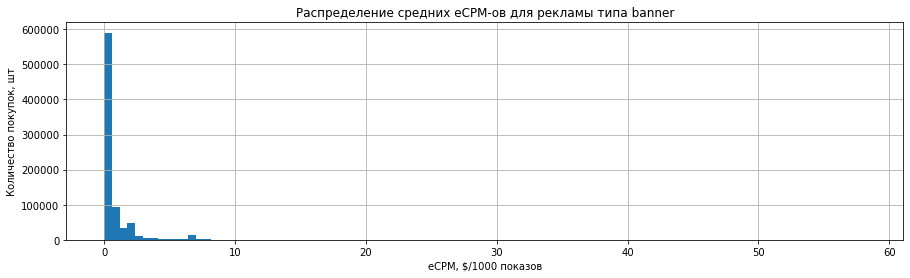

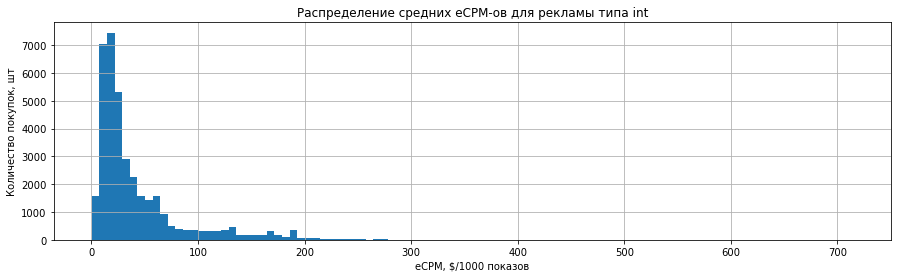

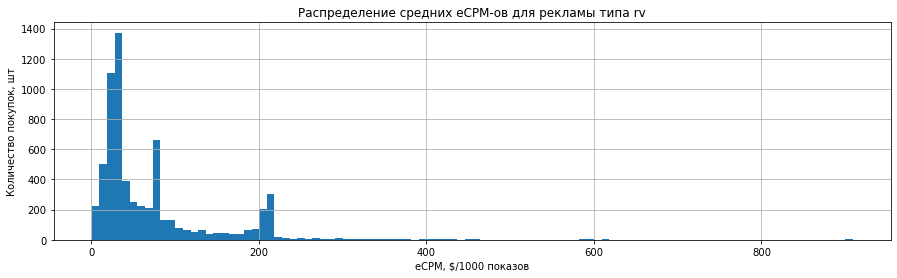

In [32]:
# Графики распределения eCPM-ов для каждого формата рекламы
for adv in df['ad_type'].unique():    

    plt.figure(figsize=(15,4))
    df[df['ad_type'] == adv]['ecpm_sma'].hist(bins=100)
    plt.title(f'Распределение средних eCPM-ов для рекламы типа {adv}')
    plt.xlabel('eCPM, $/1000 показов')
    plt.ylabel('Количество покупок, шт')
    plt.show()

In [33]:
# Описание показателей распределения по каждому типу рекламы
for adv in df['ad_type'].unique():
    print(f'Для рекламы типа {adv}')
    display(df[df['ad_type'] == adv]['ecpm_sma'].describe())
    print(100 * "-")

Для рекламы типа banner


count    815973.000000
mean          0.780694
std           1.313104
min           0.001014
25%           0.126922
50%           0.449887
75%           0.630968
max          58.174980
Name: ecpm_sma, dtype: float64

----------------------------------------------------------------------------------------------------
Для рекламы типа int


count    37610.000000
mean        42.637643
std         47.581046
min          0.335357
25%         15.361699
50%         24.564619
75%         50.757771
max        714.297668
Name: ecpm_sma, dtype: float64

----------------------------------------------------------------------------------------------------
Для рекламы типа rv


count    6482.000000
mean       71.901899
std        77.619939
min         0.554788
25%        27.162539
50%        37.592226
75%        80.059387
max       908.876160
Name: ecpm_sma, dtype: float64

----------------------------------------------------------------------------------------------------


In [34]:
# Выведем количество покупок, медиану ecpm и общую выручку по каждому типу рекламы.
pd.concat([
    df.pivot_table(index='ad_type', values='ecpm_sma', aggfunc=['count', 'median']),
    (df.pivot_table(index='ad_type', values='revenue', aggfunc='sum'))
    ], axis=1
)

,"(count, ecpm_sma)","(median, ecpm_sma)",revenue
ad_type,,,
banner,815973,0.449887,607.178931
int,37610,24.564619,1361.888664
rv,6482,37.592226,421.661652


In [35]:
# Процентное соотношение по количеству операций
df['ad_type'].value_counts(normalize=True)

banner    0.948734
int       0.043729
rv        0.007537
Name: ad_type, dtype: float64

**Вывод:**

Тип ***banner***

    Имеет распределение ecpm от 0 до 58 и большую часть значений имеет в пределах от 0.12 до 0.64. Медианное значение равно 0.45.
    При этом мы имеет самое большое количество операций по данному типу (95%) и общую выручку на втором месте в районе 607

Тип ***int***

    Имеет распределение ecpm от 0 до 700 и большую часть значений имеет в пределах от 15 до 50. Медианное значение равно 25.
    При этом мы имеет самое второе по количеству операций значение по данному типу (4%) и общую выручку на первом месте в районе 1362, что более чем в 2 раза больше, чем у типа banner.

Тип ***rv***

    Имеет распределение ecpm от 0 до 909 и большую часть значений имеет в пределах от 27 до 80. Медианное значение равно 38.
    При этом мы имеет третье по количеству операций значение по данному типу (менее 1%) и общую выручку в районе 422. Также имеются аномалии в распределении в районе 80 и 210. Рекомендуется изучить данные аномалии и их причины.


<a id='link_2.2'> </a>

### Построим распределение средних eCPM-ов по городам, версиям ОС.

In [36]:
df.head(2)

,profile_id,os_version,device_manufacturer,device_model,device_type,device_locale,event_name,event_datetime,event_timestamp,event_receive_datetime,event_receive_timestamp,connection_type,operator_name,country_iso_code,city,ad_type,view_index,session_view_index,cur_ticks,session_length,revenue,ads_ltv,ecpm_sma,normalized_ecpm_sma,value,currency,ad_country_code,network_name,ad_unit_id,ad_network_placement,creativeId
0,JLjpGzDHBQm,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,2022-02-04 20:02:28,1643994148,2022-02-06 17:58:19,1644159499,wifi,unknown,US,Norwalk,banner,1,0,637795729492245130,705.8807,0.00051,0.487877,0.511508,0.511508,0.00051,USD,US,Google AdMob,64c6b1114ea8c1cc,ca-app-pub-7511632782617496/8825263691,CJ3XirfD5vUCFYPnKAUdG3MOYQ
1,JLjpGzDHBQm,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,2022-02-04 20:02:45,1643994165,2022-02-06 17:58:19,1644159499,wifi,unknown,US,Norwalk,banner,1,0,637795729659949790,722.6512,0.00051,0.488387,0.511389,0.511389,0.00051,USD,US,Google AdMob,64c6b1114ea8c1cc,ca-app-pub-7511632782617496/8825263691,CNa-lL_D5vUCFZrpKAUdU2QBDQ


In [37]:
# Количество уникальных значений городов
df['city'].nunique()

921

In [38]:
df['city'].value_counts(normalize=True).head()

unknown        0.376360
New York       0.020445
Minneapolis    0.015092
Houston        0.011786
Springfield    0.011784
Name: city, dtype: float64

Получилось довольно много городов - 921. Также большая доля приходится на значение 'unknown', то есть город не известен. Это довольно большая часть

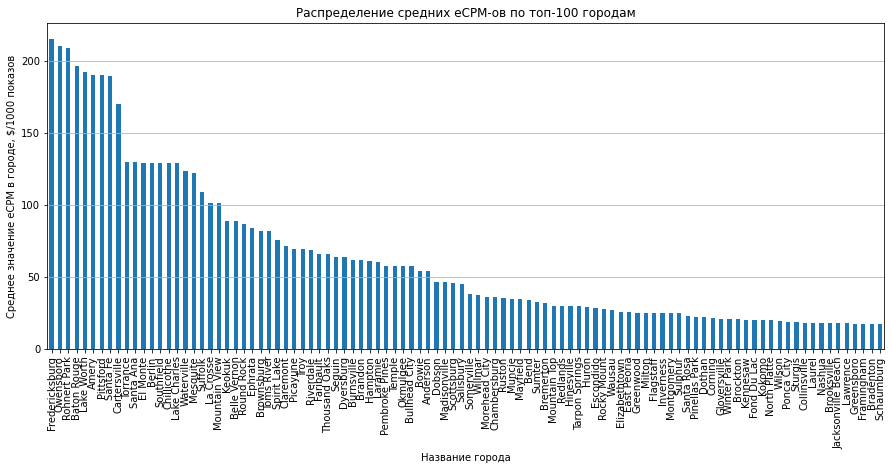

In [39]:
# Построим график распределения средних eCPM-ов по топ-100 городам
plt.figure(figsize=(15,6))
df.groupby('city')['ecpm_sma'].mean().sort_values(ascending=False).head(100).plot(kind='bar')
plt.title(f'Распределение средних eCPM-ов по топ-100 городам')
plt.xlabel('Название города')
plt.ylabel('Среднее значение eCPM в городе, $/1000 показов')
plt.grid(axis = 'y')
plt.show()

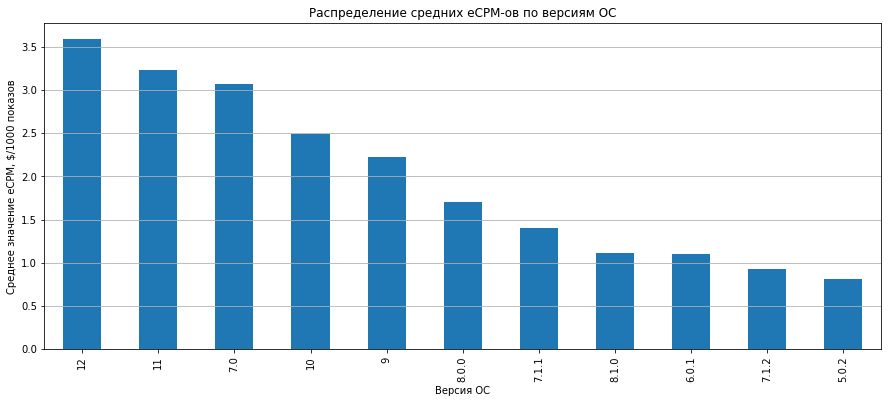

In [40]:
# Построим график распределения средних eCPM-ов по версиям ОС
plt.figure(figsize=(15,6))
df.groupby('os_version')['ecpm_sma'].mean().sort_values(ascending=False).head(100).plot(kind='bar')
plt.title(f'Распределение средних eCPM-ов по версиям ОС')
plt.xlabel('Версия ОС')
plt.ylabel('Среднее значение eCPM, $/1000 показов')
plt.grid(axis = 'y')
plt.show()

In [41]:
# Доля сделок по типу каждой операционной системы
df['os_version'].value_counts(normalize=True)

12       0.473903
11       0.243071
10       0.175418
9        0.077508
8.1.0    0.010754
8.0.0    0.009320
7.0      0.004717
7.1.2    0.002106
7.1.1    0.001560
5.0.2    0.000824
6.0.1    0.000819
Name: os_version, dtype: float64

97% всех сделок приходится на ОС 12, 11, 10, 9. Поэтому остальные операционные системы отбросим. 

Так как городов много и сложно показать распределение по городам,  поэтому возьмем топ-20 городов по количеству выручки и сделам анализ для них. 

In [42]:
# Выберем названия топ-20 городов по выручке
top_cities = df.groupby('city')['revenue'].sum().sort_values(ascending=False).head(21).index
top_cities

Index(['unknown', 'New York', 'Indianapolis', 'Houston', 'Minneapolis',
       'Cleveland', 'Charlotte', 'Columbus', 'Los Angeles', 'Spokane',
       'Dallas', 'Kansas City', 'Oklahoma City', 'Denver', 'Rocky Mount',
       'Cincinnati', 'Lee's Summit', 'Chicago', 'Las Vegas', 'Tulsa', 'Tampa'],
      dtype='object', name='city')

In [43]:
# Отберем данные в отдельную переменную
df_city = df.query('city != "unknown" & os_version in ["12", "11", "10", "9"] & city in @top_cities')

In [44]:
df_city_ecpm = df_city.pivot_table(index='city', values='ecpm_sma', columns='os_version', aggfunc=['mean'])

In [45]:
# Соберем сводные данные в одну таблицу
df_city_ecpm = pd.concat([
    df_city_ecpm,
    df_city[['city', 'ecpm_sma']].groupby(['city']).mean(),
    df_city[['city', 'revenue']].groupby(['city']).sum()
    ], axis=1
)

In [46]:
# Присвоим понятные названия столбцов
df_city_ecpm.columns = ["10","11", "12", "9", 'ecpm_sma', 'revenue']

In [47]:
# Выведем на экран сводную таблицу
df_city_ecpm.sort_values('revenue', ascending=False)

,10,11,12,9,ecpm_sma,revenue
city,,,,,,
New York,2.310712,3.046548,3.282108,1.921197,2.970385,46.838449
Indianapolis,3.046219,10.245312,6.431961,1.967919,5.936076,36.679515
Minneapolis,5.315899,2.390188,2.777335,2.224928,2.891356,34.235291
Houston,2.152732,4.885381,4.124158,1.427116,3.896622,34.225194
Cleveland,11.322410,6.379350,8.836646,3.335953,6.204736,31.896731
Charlotte,5.451842,4.693671,2.209523,1.599845,2.873125,25.448752
Columbus,2.696698,5.105381,4.141485,0.938227,4.453622,20.711336
Los Angeles,1.980390,2.730321,3.771175,18.534192,3.549402,19.740347
Spokane,0.808896,3.463886,3.291824,3.151359,3.311693,18.923951


<AxesSubplot:ylabel='city'>

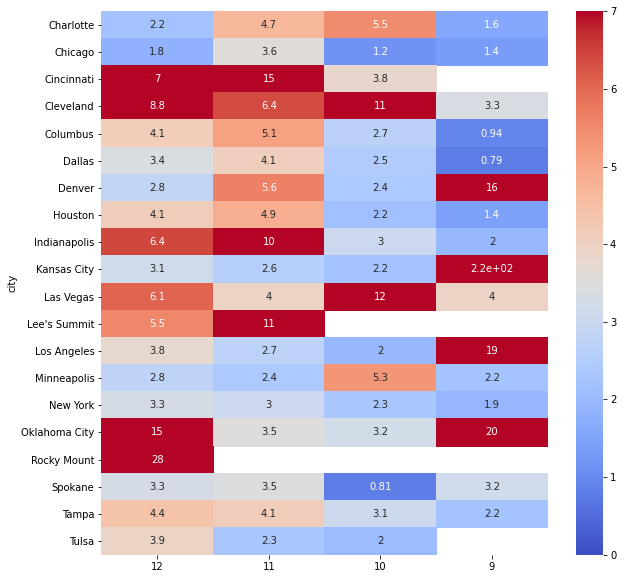

In [48]:
# Построим распределение средних eCPM-ов по городам, версиям ОС
plt.figure(figsize=(10,10))
sns.heatmap(df_city_ecpm[["12", "11", "10", "9"]], cmap='coolwarm', vmin=0, vmax=7, annot=True)

По некоторым крупным городам типа New York, Chicago ecpm распределено равномерно между ОС. 
Такие города, как Oklahoma City, Los Angeles, Kansas City, Denver имеют высокое значения ecpm для ОС 9, что может говорить о консервативных взглядах и неготовностью менять девайсы часто.

In [49]:
top_cities

Index(['unknown', 'New York', 'Indianapolis', 'Houston', 'Minneapolis',
       'Cleveland', 'Charlotte', 'Columbus', 'Los Angeles', 'Spokane',
       'Dallas', 'Kansas City', 'Oklahoma City', 'Denver', 'Rocky Mount',
       'Cincinnati', 'Lee's Summit', 'Chicago', 'Las Vegas', 'Tulsa', 'Tampa'],
      dtype='object', name='city')

<a id='link_2.3'> </a>

### Построим распределение доходов по городам, версиям ОС.

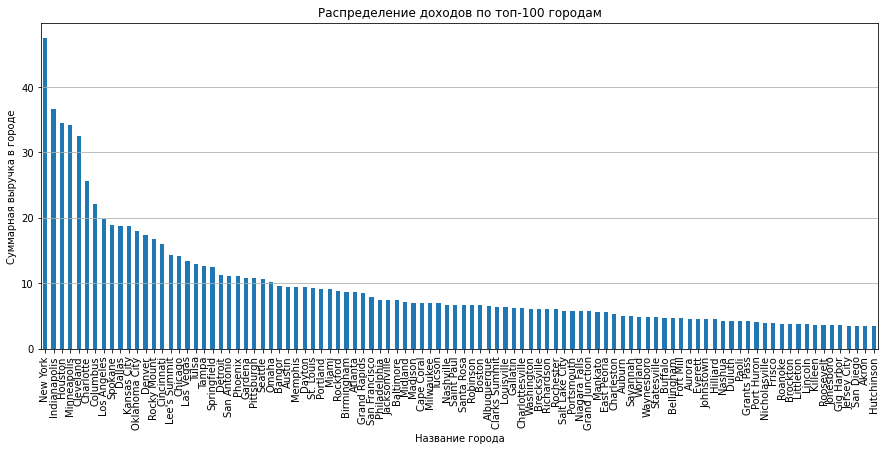

In [50]:
# Построим график распределения доходов по топ-100 городам
plt.figure(figsize=(15,6))
df.query('city != "unknown"').groupby('city')['revenue'].sum().sort_values(ascending=False).head(100).plot(kind='bar')
plt.title(f'Распределение доходов по топ-100 городам')
plt.xlabel('Название города')
plt.ylabel('Суммарная выручка в городе')
plt.grid(axis = 'y')
plt.show()

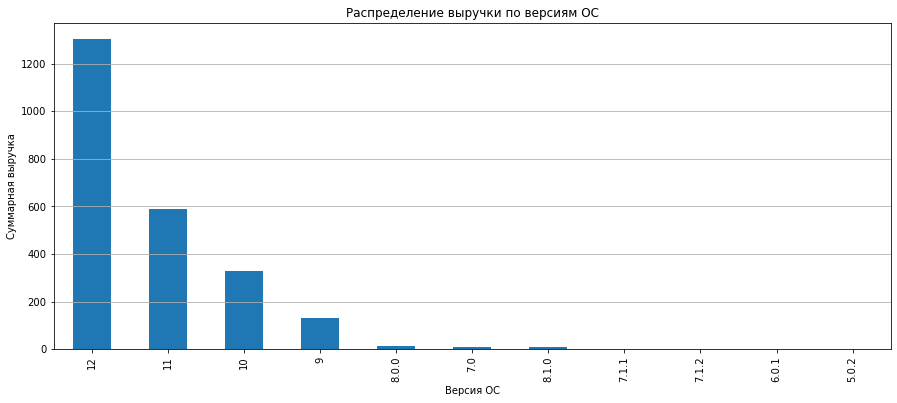

In [51]:
# Построим график распределения выручки по версиям ОС
plt.figure(figsize=(15,6))
df.groupby('os_version')['revenue'].sum().sort_values(ascending=False).plot(kind='bar')
plt.title(f'Распределение выручки по версиям ОС')
plt.xlabel('Версия ОС')
plt.ylabel('Суммарная выручка')
plt.grid(axis = 'y')
plt.show()

Большая часть выручки приходится на операционные системы "12", "11", "10", "9"

In [52]:
# Соберем сводную таблицу по версиям ОС и топ-20 городов
df_city_rev = df_city.pivot_table(index='city', values='revenue', columns='os_version', aggfunc=['sum'])
df_city_rev

sum                                
os_version           10         11         12         9
city                                                   
Charlotte      6.183888   6.601319  10.073750  2.589795
Chicago        4.190294   4.837461   4.572891  0.452045
Cincinnati     0.459409   0.924117  14.614487       NaN
Cleveland      0.129124   8.501822  16.839890  6.425895
Columbus       1.351679  14.041226   5.280875  0.037557
Dallas         1.292852   4.397966  12.370629  0.057018
Denver         2.598518   5.301424   8.518278  0.973186
Houston        0.492315   8.517705  23.660587  1.554586
Indianapolis   2.372959   2.902682  30.871253  0.532621
Kansas City    1.596577   5.828766  10.689344  0.574662
Las Vegas      5.345983   5.077822   2.461814  0.531059
Lee's Summit        NaN   3.331120  11.006649       NaN
Los Angeles    1.247949   4.615237  11.768150  2.109011
Minneapolis    5.914732   9.880403  16.781748  1.658408
New York       7.622460  13.444453  24.521462  1.250074
Oklahoma City  4.800746   0.950834  11.923797  0.233815
Rocky Mount         NaN        NaN  16.693398       NaN
Spokane        0.002815   2.450274  16.375592  0.095269
Tampa          0.280963  10.239379   2.127480  0.026573
Tulsa          4.469612   2.124026   6.402689       NaN

<AxesSubplot:xlabel='None-os_version', ylabel='city'>

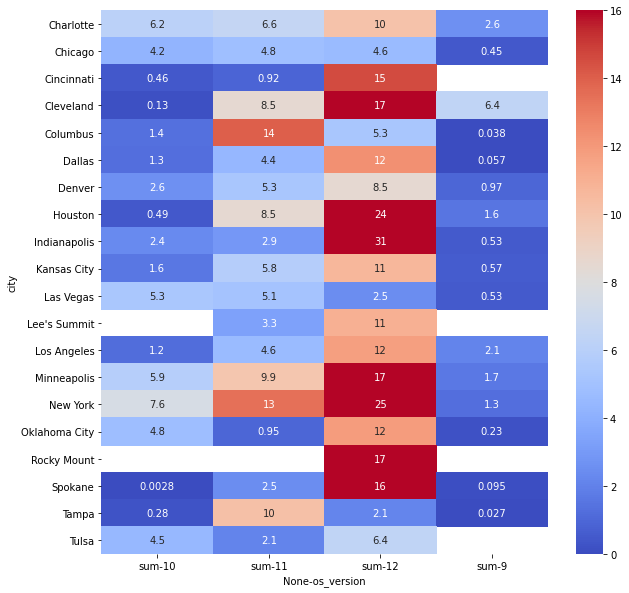

In [53]:
# Построим распределение доходов по городам, версиям ОС
plt.figure(figsize=(10,10))
sns.heatmap(df_city_rev, cmap='coolwarm', vmin=0, vmax=16, annot=True)

Если говорить об общей выручке, то можно заметить, что большая часть выручки приходится на девайсы с ОС 12 в независимости от города. 

<a id='link_2.4'> </a>

### Построим распределение средних eCPM-ов по времени суток

In [54]:
df['hour'] = df['event_datetime'].dt.hour

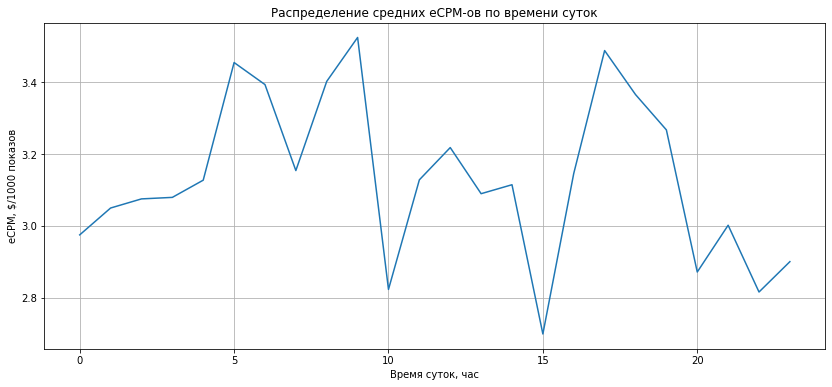

In [55]:
plt.figure(figsize=(14,6))
df.groupby('hour')['ecpm_sma'].mean().plot()
plt.grid('both')
plt.title(f'Распределение средних eCPM-ов по времени суток')
plt.ylabel('eCPM, $/1000 показов')
plt.xlabel('Время суток, час')
plt.show()

Видны пики в 5, 9, 17 часов, а также минимумы в 10, 15, 20 часов

<a id='link_2.5'> </a>

### Проверим стоимость рекламы в разных компаниях

In [56]:
df.pivot_table(index=['ad_type', 'network_name'], values='revenue', aggfunc=['sum', 'count', 'mean'])

sum   count      mean
                         revenue revenue   revenue
ad_type network_name                              
banner  AppLovin       38.662116  333357  0.000116
        Facebook        7.979081   11149  0.000716
        Google AdMob  560.537733  471467  0.001189
int     AppLovin      724.926967   23093  0.031392
        Facebook       95.447110    4010  0.023802
        Google AdMob  541.514588   10507  0.051538
rv      AppLovin      143.652100    2799  0.051323
        Facebook       29.943917     929  0.032232
        Google AdMob  248.065635    2754  0.090075

Средняя стоимость рекламы в в компании Google AdMob по всем трем типам выше AppLovin.
большую часть выручки компания AppLovin имеет в типе рекламы int, во всех других компания Google AdMob существенно превосходит. 

## Вывод:

**Данная работа состояла из двух частей: предобработка данных, анализ данных**

***Предобработка***

    Стобец event_json имел внутри себя дополнительную информацию, которая была преобразована в отдельные столбцы. Столбец удален.
    Произведен анализ и обработка пропусков. Столбец 'placement' удален, так как имел значительное количество пропусков. Пропуски в столбцах 'city' и 'operator_name' заполнены значением 'unknown'. Строки с пустыми значениями столбца 'profile_id' удалил.
    В столбце 'network_name' значения 'APPLOVIN_EXCHANGE' и 'AppLovin'привел к одному значению.







***Распределение средних eCPM-ов юзеров для каждого формата рекламы***

Тип ***banner***

    Имеет распределение ecpm от 0 до 58 и большую часть значений имеет в пределах от 0.12 до 0.64. Медианное значение равно 0.45.
    При этом мы имеет самое большое количество операций по данному типу (95%) и общую выручку на втором месте в районе 607

Тип ***int***

    Имеет распределение ecpm от 0 до 700 и большую часть значений имеет в пределах от 15 до 50. Медианное значение равно 25.
    При этом мы имеет самое второе по количеству операций значение по данному типу (4%) и общую выручку на первом месте в районе 1362, что более чем в 2 раза больше, чем у типа banner.

Тип ***rv***

    Имеет распределение ecpm от 0 до 909 и большую часть значений имеет в пределах от 27 до 80. Медианное значение равно 38.
    При этом мы имеет третье по количеству операций значение по данному типу (менее 1%) и общую выручку в районе 422. Также имеются аномалии в распределении в районе 80 и 210. Рекомендуется изучить данные аномалии и их причины.

***Распределение средних eCPM-ов по городам, версиям ОС***

    Данные распределения по городам дают топ городов, в которых показатель наивысший
    То же самое касается и версий ОС

***Распределение доходов по городам, версиям ОС***

    Распределение по городам дает топ городов, в которых реклама приносит больше всего выручки
    Что касается ОС, то здесь ничего необычного - более новые версии приносят больше всего денег. 

***Распределение средних eCPM-ов по времени суток.***

    Видны пики в 5, 9, 17 часов, что может быть привязано ко времени подъема, времени начала рабочего дня и концу рабочего дня. 
    Есть небольшой всплеск в 12 часов, что может быть привязано к обеденному времени.
    Также имеются минимумы в 10, 15, 20 часов, что может соответствовать периодам активной работы или учебы утром и днем, а также в 20 - вечернее время с домашними заботами. 
    Теоретически можно переложить на временную шкалу и посмотреть зависимость от дня недели и времени года. 

***Стоимость рекламы в разных компаниях***

    Средняя стоимость рекламы в в компании Google AdMob по всем трем типам выше AppLovin. 
    Большую часть выручки компания AppLovin имеет в типе рекламы int, во всех других компания Google AdMob существенно превосходит конкурентов.